**линейная регрессия, аналитическое решение**

Евгений Борисов  <esborisov@sevsu.ru>

# генерируем набор данных

In [1]:
import numpy as np
import numpy.random as rng
from matplotlib import pyplot as plt

In [2]:
np.set_printoptions(precision=2)

In [4]:
# f,xlim = (lambda x: np.sin(x*2.9)),(-1.,+2.)
f,xlim = lambda x: np.sin(x*2.9)+np.cos(x*5.9),(-1,1)
# f,xlim = lambda x: np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2), (-3,5)

In [3]:
def generate(f, xlim=(-1.,1.), n_samples=256, noise=.1 ):
    assert len(xlim)==2
    assert xlim[0]<xlim[1]
    assert n_samples>2
    assert 0.<noise<1.
    x = np.sort( rng.rand(n_samples)*(xlim[1]-xlim[0]) + xlim[0] )
    return x.reshape(-1,1), ( f(x)+rng.normal(0.,noise,n_samples) ).reshape(-1,1)

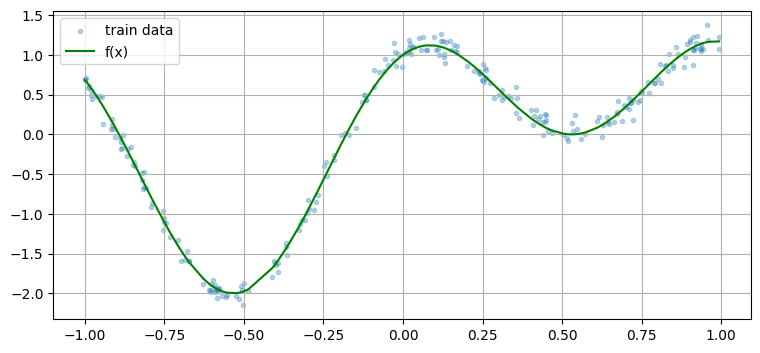

In [5]:
X_train,y_train = generate(f=f,xlim=xlim)

# рисуем результат
fig,ax = plt.subplots(figsize=(9,4))
ax.scatter(x=X_train,y=y_train,alpha=.3,marker='.',label='train data') # точки учебного набора
ax.plot(X_train,f(X_train),c='g',label='f(x)')
ax.grid()
ax.legend()

## модель

$$a(x,w) = \sum\limits_{i=1} x_i \cdot w_i + w_0$$

In [6]:
class LinearRegression:
    
    def __init__( self, weight=np.array([]) ):
        self._weight = weight
    
    def score(self,x):
        assert len(x)>0
        assert x.shape[1]==len(self._weight)
        return x.dot(self._weight)
    
    def predict(self,x): 
        return self.score(x)
    
    @property
    def weight(self): return self._weight

    @weight.setter
    def weight(self,value): self._weight = value
            
    def score_partial(self,x): # частные производные модели по её параметрам
        return x

## обучаем модель

функция потери средняя квадратичная ошибка
$$L=MSQE(y,o)=\frac{1}{m}\sum\limits_{i=0}^m(o_i-y_i)^2$$

частные производные функции потери по параметрам модели (градиент)

$$ \nabla L = \frac{\partial L }{\partial w} = 2 \cdot( o - y ) \cdot \frac{\partial o }{\partial w}  $$

In [7]:
class MSQELoss:

    @staticmethod
    def score(target,predicted): 
        d = predicted - target
        return d.T.dot(d).flatten()[0]/len(d)
    
    @staticmethod
    def partial( target, predicted, model_partial, ): # градиент функции потери,
        g = model_partial.T.dot( predicted - target ) # градиент msqe
        g /= np.abs(g).max() # нормируем градиент
        return g

In [8]:
from tqdm.auto import tqdm

изменение весов

$$\Delta w_t = \eta \cdot ( \nabla L + \rho\cdot W_{t-1} ) + \mu\cdot \Delta w_{t-1}$$

In [9]:
class RegressionTrainSGD:
    
    def __init__(self,model,loss):
        self._model = model
        self._loss = loss   
        self._dw = np.array([])
        self._mu = 0.
        self._rho = 0.
        self._lr = .1     
        self._bs = 1     
        
    
    def fit( self, X, target, lr=1e-4, n_epoch=512, loss_min=1e-3, batch_size=10,rho=1e-2,mu=1e-3 ): 
        # n_epoch - максимальное число циклов обучения
        # loss_min - порог минимально допустимой погрешности модели
        self._mu = mu # коэфициент момента
        self._rho = rho # коэфициент регуляризации
        self._lr = lr   # скорость обучения
        self._bs = batch_size # размер пакета данных для одного цикла обучения

        # n_samples = len(target) # количество примеров
        n_param = X.shape[1] # размер вектора признаков

        # инициализация параметров модели
        self._model.weight = rng.normal(size=(n_param,1),scale=1e-3)
        self._dw = np.zeros((n_param,1))

        # начальное значение ф-ции потери
        loss_history = [ self._loss.score(target,self._model.score(X)) ]

        for i in tqdm(range(n_epoch)): # цикл обучения
            self._fit_epoch(X,target) # корректируем веса модели
            loss_history.append(  self._loss.score(target,self._model.score(X)) ) # считаем значение ф-ции потери

            if loss_history[-1] < loss_min: # проверяем достижение минимального порога погрешности модели
                print('step %i/%i: loss threshold %.03f reached\n'%(
                    i+1,n_epoch,loss_history[-1]
                    ))
                break   
        return loss_history, self._model
    
    @property
    def model(self): return self._model
    
    def _fit_epoch(self,X,target):
        for x,y in self._get_batch(X,target):
            self._fit_batch(x,y)
        return self
    
    def _fit_batch(self,X,target):
        # градиент функции потери, изменение весов
        g = self._loss.partial(target,self._model.score(X),self._model.score_partial(X) ) 
        self._weight_adjust(g) # корректируем параметры    
        return self
        
    def _weight_adjust(self,g):
        self._dw = self._lr*(g + self._rho*self._model.weight ) + self._mu * self._dw
        self._model.weight = self._model.weight - self._dw   # корректируем параметры
        return self
    
      # генератор батчей
    def _get_batch(self,x,y): 
        n_samples = len(y) # количество учебных пар
        batch_count = np.ceil( n_samples/self._bs).astype(int) # количество батчей
        # перемешиваем учебный набор и режем его на батчи
        for idx in np.array_split(rng.permutation(n_samples), batch_count ):
            yield x[idx,:],y[idx,:]
        

In [10]:
from sklearn.preprocessing import PolynomialFeatures

# собираем полином, добавляем столбец из единиц (свободный член)
poly = PolynomialFeatures( 
        degree=7, 
        interaction_only=False, 
        include_bias=True,
    ).fit( X_train )

  0%|          | 0/2048 [00:00<?, ?it/s]

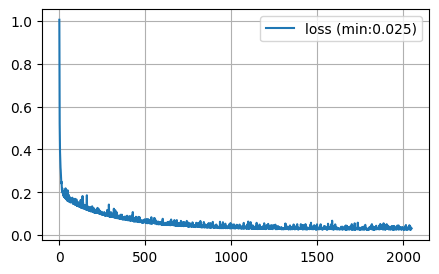

In [11]:
loss_history,model = RegressionTrainSGD(
        model=LinearRegression(),
        loss=MSQELoss(),
    ).fit(
        poly.transform(X_train),  y_train,
        lr=1e-1, n_epoch=1024*2, loss_min=1e-3,batch_size=len(X_train)//7,rho=1e-3,mu=1e-3
)

# история изменения значений погрешности модели
fig,ax = plt.subplots(figsize=(5,3))
ax.plot(loss_history,label=f'loss (min:{min(loss_history):.3f})' )
ax.grid()
ax.legend()

## тестируем

In [14]:
X_test,y_test = generate(f=f,xlim=xlim)

predicted = model.predict(poly.transform(X_test))

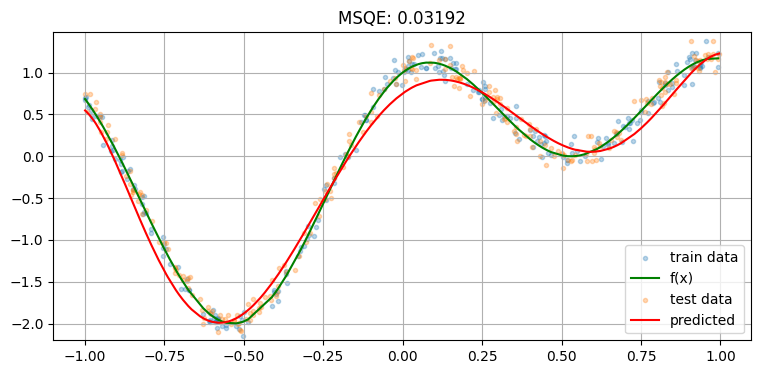

In [31]:
from sklearn.metrics import mean_squared_error

# рисуем результат
fig,ax = plt.subplots(figsize=(9,4))
ax.scatter(x=X_train,y=y_train,alpha=.3,marker='.',label='train data') # точки учебного набора
ax.plot(X_train,f(X_train),c='g',label='f(x)')
ax.scatter(x=X_test,y=y_test,alpha=.3,marker='.',label='test data') # точки учебного набора
ax.plot(X_test,predicted,c='r',label='predicted')
ax.set_title(f'MSQE: {mean_squared_error(y_true=y_test,y_pred=predicted):.5f}')
# ax.set_xlim(X_test.min()-.1,X_test.max()+.1)
ax.set_ylim(y_test.min()-.1,y_test.max()+.1)
ax.grid()
ax.legend()